# FIN 514 - Project -1 Issuer callable barrier notes

**Spring 2023**


In [3]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

### Parameter Set up

In [4]:
# ENTER INPUT FOR: N = num_steps

N = 100

In [5]:
# ENTER INPUT FOR: S0 = Original Stock Price

S0 = 127.79

In [6]:
# ENTER INPUT FOR: sigma = Annualized (Future) Volatility of Stock Price Returns

sigma = 0.4780

In [7]:
# ENTER INPUT FOR: Annualized Continously Compounded Risk-free Rate

# r1 is the risk neutral rate for calculation of probability; between trade date and valuation date
r1 = 0.037395 

# r2 is the risk free rate for discounting the value between trade date and maturity date
r2 = 0.03738

In [8]:
# ENTER INPUT FOR: T = Option maturity

T = 916/365

In [9]:
# ENTER INPUT FOR: DIV = Size of proportional dividend
# ND as number of dividend dates
DIV = 0.02912/2
ND = 5

In [10]:
#Enter INPUT FOR: Dates when dividends are paid, assuming dividends are distributed biannually and equally spaced between dates 
TD = np.zeros([ND])
TD = [180/365, 360/365, 540/365, 720/365, 900/365]
TD

[0.4931506849315068,
 0.9863013698630136,
 1.4794520547945205,
 1.9726027397260273,
 2.4657534246575343]

### Issuer callable valuation 

In [11]:
#key details
Face = 1000
ratio = 0.5

In [12]:
#Size of coupon and number of coupons per year
cpn = 0.155/12
nc = 12

In [13]:
#Coupon dates
tco = [35/365,  62/365,  95/365,  125/365,  154/365,  186/365,  216/365,  248/365,  278/365,  308/365,  
       340/365,  370/365,  399/365,  430/365,  461/365,  489/365,  522/365,  552/365,  581/365,  614/365,  
       643/365,  675/365,  706/365,  735/365,  767/365,  795/365,  825/365,  854/365,  887/365,  916/365]

In [14]:
#Issuer call observation dates
tac = [32/365,  59/365,  90/365,  122/365,  151/365,  181/365,  213/365,  243/365,  273/365,  304/365,  
       334/365,  367/365,  396/365,  425/365,  458/365,  486/365,  517/365,  549/365,  578/365,  609/365,  
       640/365,  670/365,  700/365,  732/365,  762/365,  790/365,  822/365,  851/365,  882/365,  913/365]

In [57]:

def Bin_icall(N, S0, Face, ratio, sigma, r1, r2, T, cpn, tco, tac, DIV, TD):
    
    
    ######################################################################################
    def Stock_tree(N, S0, sigma, r, T, DIV, TD):
    
        stock_value = np.zeros([N+1, N+1])    

        delta = T / N
        u = np.exp(r*delta + sigma * (delta)**0.5)
        d = np.exp(r*delta - sigma * (delta)**0.5)
        print("u = ", u, "d=", d)

        # FIRST LET'S BUILD A STOCK PRICE TREE WITH DIVIDENDS  
        # Let's have dividends at grid points rather than times
        jD1 = [i/delta for i in TD]
        #print(jD1)
        jD = [np.ceil(i) for i in jD1]
        print(jD)

        stock_value[0,0] = S0
        #print(stock_value[0,0])
        for j in range (1,N+1):
            stock_value[j, 0] = stock_value[j-1, 0]*d 
            for i in range(1, j+1):    
                stock_value[j, i] = stock_value[j-1, i-1]*u      

        # This adjusts all stock prices for that j by the size of the dividend    
            if j in jD: stock_value[j, :] *= (1-DIV)
        print(stock_value[3,0], stock_value[4,0], stock_value[5,0])        
        return stock_value
    
    ######################################################################################
    
    stock_value = Stock_tree(N, S0, sigma, r1, T, DIV, TD)
    

    # LIST TO SAVE RESULTS
    icall_result = []
        
    # CREATE TWO DIMENSIONAL ARRAY OF SIZE [N+1,N+1] TO STORE ALL STEPS
    # option_value[N+1, N+1]
    option_value = np.zeros([N+1, N+1])
    
    #########################################################################################
    #ex_boundary = np.zeros([N+1])
    #option_tree = option_value
    ########################################################################################

    
    delta = T / N
    u = np.exp(r1*delta+sigma * (delta)**0.5)
    d = np.exp(r1*delta-sigma * (delta)**0.5)
    q = (np.exp(r1 * delta) - d) / (u - d)

    #First, let's calculate the coupon dates and accrued interest

    #jC1 are the exact values of j where the coupons are paid
    #jC are the values of j where we first factor in the coupons - 
    #where int will give us the j immediately before or on the call date
    jco1 = [j/delta for j in tco]
    jco = [int(j) for j in jco1]
    
    jac1 = [j/delta for j in tac]
    jac = [int(j) for j in jac1]
    #This converts the call times into times steps, 
    #where int will give us the j immediately before the call date
    
    j = N
    for i in range(0, j+1): 
        option_value[j, i] = (Face *(1+cpn))*np.exp(-r2*3/365) 
        if stock_value[j,i] < ratio*S0: option_value[j, i] = Face*(stock_value[j,i]/S0)*np.exp(-r2*3/365)
            
        ########################################################################
        #ex_boundary[j] = round(option_value[j,i])
        #option_tree[j,i] = round(option_value[j,i])
        ########################################################################
  
        
        
    for j in range(N-1, -1, -1):
        
        #######################################################################
        #ex_boundary[j] = 0
        #########################################################################

        #if j in jac: print("call",j,jac.index(j))    
        for i in range(0, j+1):           
            cont = np.exp(-r2 * delta) * (q * option_value[j + 1, i + 1] + (1-q) * option_value[j + 1, i])

                    
            # the "if j in jC" is a really great Python command as it will check whether the entry ever occurs 
            # in the array jC. The index command is a little erratic but here will find the equivalent entry in 
            # the tc array - again a feature that may be helpful in future projects.
            
            if j in jac:
            
                if stock_value[j,i] >= ratio*S0: 
                    cont = cont + Face*cpn*np.exp(-r2*(tco[jac.index(j)]-delta*j))                        
                
                exe = Face *(1+cpn)
                cont = min(cont, exe)
                
            
            option_value[j,i] = cont
            
            ############################################################# use below line to plot barrier##################
            #ex_boundary[j] = max(option_value[j,:])
            #if ex_boundary[j] > 1013: print(j)
            #option_tree[j,i] = round(option_value[j,i])
            ##############################################################################################################

    output = {'num_steps': N, 'Value': option_value[0,0]}
    icall_result.append(output)

    return icall_result, #ex_boundary, option_value

In [61]:
steps = np.arange(100, 1000)

sst = []
boundary =[]
for i in range(len(steps)):
    result = Bin_icall(steps[i], S0, Face, ratio, sigma, r1, r2, T, cpn, tco, tac, DIV, TD)
    sst.append(result[0])   
    print(steps[i])
df = pd.DataFrame.from_dict(sst)
df

u =  1.0796767633272395 d= 0.927943175396594
[20.0, 40.0, 59.0, 79.0, 99.0]
102.10829310412306 94.75069373736609 87.92325961768167
100
u =  1.0792610687697255 d= 0.9282833366572877
[20.0, 40.0, 60.0, 80.0, 100.0]
102.22062547713645 94.88970329311117 88.08453038734926
101
u =  1.0788517077531175 d= 0.9286186471387554
[21.0, 41.0, 61.0, 81.0, 101.0]
102.33143656739958 95.02688018498397 88.24373291919642
102
u =  1.078448522095893 d= 0.9289492217857411
[21.0, 41.0, 61.0, 81.0, 102.0]
102.44076095708898 95.16226517022695 88.40091217325066
103
u =  1.0780513590726688 d= 0.9292751717516907
[21.0, 41.0, 62.0, 82.0, 103.0]
102.54863212772828 95.29589773339565 88.5561117334328
104
u =  1.0776600711751703 d= 0.9295966045584159
[21.0, 42.0, 62.0, 83.0, 104.0]
102.6550825050908 95.42781613739645 88.70937386174855
105
u =  1.0772745158858537 d= 0.9299136242476012
[21.0, 42.0, 63.0, 84.0, 105.0]
102.76014350187349 95.55805747203075 88.86073954987668
106
u =  1.0768945554634 d= 0.9302263315246447
[22

162
u =  1.0617163148846962 d= 0.9429563574088551
[33.0, 65.0, 97.0, 129.0, 161.0]
107.14493574872134 101.03299832842009 95.26970808186195
163
u =  1.0615203259138768 d= 0.9431238339260086
[33.0, 65.0, 97.0, 129.0, 162.0]
107.20203525632944 101.10479449562057 95.35434141301089
164
u =  1.0613261682969326 d= 0.9432898249424585
[33.0, 65.0, 98.0, 130.0, 163.0]
107.25864831034026 101.17599158822559 95.43828339363697
165
u =  1.0611338138353592 d= 0.9434543524018999
[33.0, 66.0, 98.0, 131.0, 164.0]
107.31478186735154 101.2465980298133 95.52154357711298
166
u =  1.0609432349330368 d= 0.9436174377955654
[33.0, 66.0, 99.0, 132.0, 165.0]
107.37044274446474 101.31662207750728 95.60413133087903
167
u =  1.0607544045798158 d= 0.9437791021741735
[34.0, 67.0, 100.0, 133.0, 166.0]
107.4256376228784 101.3860718262083 95.68605584110513
168
u =  1.0605672963356483 d= 0.9439393661594915
[34.0, 67.0, 100.0, 133.0, 167.0]
107.48037305136822 101.4549552126942 95.76732611721016
169
u =  1.060381884315238 d=

221
u =  1.052580578397151 d= 0.9508495959769783
[44.0, 88.0, 131.0, 175.0, 219.0]
109.85816713661151 104.4585938366184 99.32441174587188
222
u =  1.0524585128527575 d= 0.9509562714148186
[44.0, 88.0, 132.0, 176.0, 220.0]
109.89514611713757 104.50547839813983 99.38014007991693
223
u =  1.0523372840780958 d= 0.9510622475671346
[45.0, 89.0, 133.0, 177.0, 221.0]
109.93189090663375 104.55207124496815 99.4355278660386
224
u =  1.0522168825986005 d= 0.951167532074405
[45.0, 89.0, 133.0, 177.0, 222.0]
109.9684039939419 104.59837543307886 99.49057861967368
225
u =  1.0520972990888435 d= 0.9512721324604511
[45.0, 89.0, 134.0, 178.0, 223.0]
110.00468783079846 104.64439397344988 99.54529580515523
226
u =  1.0519785243695328 d= 0.9513760561347203
[45.0, 90.0, 134.0, 179.0, 224.0]
110.04074483254531 104.69012983291407 99.59968283666961
227
u =  1.051860549404587 d= 0.9514793103945157
[45.0, 90.0, 135.0, 180.0, 225.0]
110.07657737882455 104.73558593499253 99.65374307919222
228
u =  1.051743365298279

u =  1.0464728533130851 d= 0.9562271906310483
[56.0, 111.0, 167.0, 222.0, 278.0]
111.73265963907546 106.84180722840826 102.16504116796486
282
u =  1.0463881811575289 d= 0.9563023180077277
[56.0, 112.0, 167.0, 223.0, 279.0]
111.75899702377443 106.87538791205422 102.20518119827253
283
u =  1.0463039655658464 d= 0.9563770560652747
[56.0, 112.0, 168.0, 224.0, 280.0]
111.78520203132308 106.90880243037873 102.24512573582969
284
u =  1.0462202024657636 d= 0.9564514081678305
[57.0, 113.0, 169.0, 225.0, 281.0]
111.81127577786083 106.94205216677662 102.28487638727108
285
u =  1.0461368878355632 d= 0.9565253776388876
[57.0, 113.0, 169.0, 225.0, 282.0]
111.83721936632251 106.97513848845475 102.32443474064148
286
u =  1.0460540177032813 d= 0.9565989677619201
[57.0, 113.0, 170.0, 226.0, 282.0]
111.86303388663937 107.00806274667592 102.36380236567297
287
u =  1.0459715881459206 d= 0.9566721817810022
[57.0, 114.0, 170.0, 227.0, 283.0]
111.88872041593625 107.0408262769983 102.4029808140572
288
u =  1.0

340
u =  1.0421455774289563 d= 0.9600871414528832
[68.0, 135.0, 202.0, 269.0, 336.0]
113.09120451196729 108.57741126335809 104.24377640619156
341
u =  1.0420822174052367 d= 0.9601439708010102
[68.0, 135.0, 202.0, 269.0, 337.0]
113.11128793850685 108.60312114369438 104.27463197628987
342
u =  1.0420191397150596 d= 0.960200555908465
[68.0, 135.0, 203.0, 270.0, 338.0]
113.13128741291793 108.62872506452412 104.30536219458386
343
u =  1.0419563422753404 d= 0.9602568985260126
[68.0, 136.0, 203.0, 271.0, 338.0]
113.1512035237162 108.65422376016934 104.3359679196916
344
u =  1.041893823024405 d= 0.9603130003868622
[68.0, 136.0, 204.0, 272.0, 339.0]
113.171036853628 108.67961795779965 104.36645000195249
345
u =  1.0418315799217066 d= 0.9603688632068939
[68.0, 136.0, 204.0, 272.0, 340.0]
113.1907879796638 108.70490837752226 104.3968092835306
346
u =  1.0417696109475492 d= 0.9604244886848807
[69.0, 137.0, 205.0, 273.0, 341.0]
113.21045747319037 108.7300957324703 104.42704659851593
347
u =  1.0417

399
u =  1.0388312013976977 d= 0.963072094071381
[79.0, 158.0, 236.0, 315.0, 394.0]
114.14930377946344 109.93400902767806 105.87437628394801
400
u =  1.0387815219917467 d= 0.9631170257046151
[79.0, 158.0, 237.0, 316.0, 394.0]
114.16528125604133 109.95452612204937 105.8990761614286
401
u =  1.038732031189164 d= 0.9631617923621897
[79.0, 158.0, 237.0, 316.0, 395.0]
114.18120155069478 109.97497073963562 105.92368993256682
402
u =  1.0386827278035573 d= 0.9632063950545563
[80.0, 159.0, 238.0, 317.0, 396.0]
114.19706500652599 109.99534331074672 105.94821810313265
403
u =  1.0386336106589373 d= 0.963250834783507
[80.0, 159.0, 239.0, 318.0, 397.0]
114.21287196374828 110.01564426210234 105.97266117471543
404
u =  1.0385846785895996 d= 0.9632951125422694
[80.0, 160.0, 239.0, 319.0, 398.0]
114.22862275971731 110.03587401687032 105.99701964476807
405
u =  1.0385359304400095 d= 0.9633392293156009
[80.0, 160.0, 240.0, 320.0, 399.0]
114.24431772896213 110.05603299470502 106.02129400665147
406
u =  1

458
u =  1.0361884619715183 d= 0.9654701202758689
[91.0, 181.0, 271.0, 361.0, 451.0]
115.00411572247856 111.03303743880132 107.19908001063456
459
u =  1.0361481722243728 d= 0.9655068034823413
[91.0, 181.0, 272.0, 362.0, 452.0]
115.0172250251695 111.04991327946055 107.21944679744317
460
u =  1.0361080157006428 d= 0.9655433691160092
[91.0, 182.0, 272.0, 363.0, 453.0]
115.03029330282389 111.06673694601129 107.23975138757328
461
u =  1.0360679916700168 d= 0.9655798178055314
[91.0, 182.0, 273.0, 364.0, 454.0]
115.04332077063448 111.08350870945254 107.25999410087235
462
u =  1.036028099407765 d= 0.9656161501748621
[91.0, 182.0, 273.0, 364.0, 455.0]
115.05630764221006 111.10022883880545 107.28017525487351
463
u =  1.0359883381946862 d= 0.9656523668432968
[92.0, 183.0, 274.0, 365.0, 456.0]
115.06925412959042 111.1168976011318 107.30029516481717
464
u =  1.035948707317053 d= 0.9656884684255166
[92.0, 183.0, 275.0, 366.0, 457.0]
115.0821604432613 111.13351526155257 107.32035414367247
465
u =  1.

516
u =  1.0340514823504583 d= 0.9674209881410989
[102.0, 204.0, 305.0, 407.0, 508.0]
115.70267121637364 111.93319251870888 108.28651971223721
517
u =  1.0340178640734219 d= 0.9674517631619454
[102.0, 204.0, 306.0, 408.0, 509.0]
115.71371356123505 111.94743620683316 108.30374453976015
518
u =  1.0339843444426988 d= 0.9674824504956463
[102.0, 204.0, 306.0, 408.0, 510.0]
115.724725142732 111.96164066402548 108.32092247114437
519
u =  1.0339509229782102 d= 0.9675130505590404
[103.0, 205.0, 307.0, 409.0, 511.0]
115.7357061044874 111.97580607175716 108.33805372129329
520
u =  1.0339175992031362 d= 0.9675435637661929
[103.0, 205.0, 308.0, 410.0, 512.0]
115.74665658918339 111.98993261032018 108.35513850372497
521
u =  1.0338843726438876 d= 0.9675739905284193
[103.0, 206.0, 308.0, 411.0, 513.0]
115.75757673856903 112.00402045883696 108.3721770305836
522
u =  1.0338512428300775 d= 0.9676043312543088
[103.0, 206.0, 309.0, 412.0, 514.0]
115.76846669346833 112.01806979527014 108.38916951265085
523

574
u =  1.0322511352605825 d= 0.9690727772211253
[113.0, 226.0, 339.0, 452.0, 565.0]
116.2963411240815 112.69961827376902 109.21413207232203
575
u =  1.0322225346712643 d= 0.969099078879305
[114.0, 227.0, 340.0, 453.0, 566.0]
116.30581059748891 112.71185391833743 109.22895381103959
576
u =  1.0321940095082787 d= 0.969125313081351
[114.0, 227.0, 341.0, 454.0, 567.0]
116.3152562964875 112.72405917447104 109.24373913925997
577
u =  1.0321655594415993 d= 0.9691514801159133
[114.0, 228.0, 341.0, 455.0, 568.0]
116.32467832108398 112.73623416888604 109.25848820747011
578
u =  1.0321371841432143 d= 0.9691775802699131
[114.0, 228.0, 342.0, 456.0, 569.0]
116.33407677069472 112.74837902755621 109.27320116528195
579
u =  1.0321088832871117 d= 0.9692036138285556
[114.0, 228.0, 342.0, 456.0, 570.0]
116.34345174415026 112.7604938757186 109.28787816143917
580
u =  1.0320806565492628 d= 0.969229581075344
[115.0, 229.0, 343.0, 457.0, 571.0]
116.35280333969995 112.77257883787927 109.30251934382392
581
u

632
u =  1.0307075857300019 d= 0.9704949977287962
[125.0, 249.0, 374.0, 498.0, 622.0]
116.80912583492285 113.36267231186612 110.01790640783479
633
u =  1.0306828704418136 d= 0.970517815843786
[125.0, 250.0, 374.0, 499.0, 623.0]
116.8173652181432 113.3733341441382 110.03084062849673
634
u =  1.0306582143393015 d= 0.9705405807495613
[125.0, 250.0, 375.0, 500.0, 624.0]
116.82558577416322 113.38397186366406 110.04374590025243
635
u =  1.030633617187247 d= 0.9705632926531443
[125.0, 250.0, 375.0, 500.0, 625.0]
116.83378757505017 113.39458556197872 110.05662233207276
636
u =  1.0306090787517364 d= 0.9705859517604299
[126.0, 251.0, 376.0, 501.0, 626.0]
116.84197069248425 113.4051753301291 110.06947003235177
637
u =  1.0305845988001512 d= 0.9706085582761933
[126.0, 251.0, 377.0, 502.0, 627.0]
116.85013519776132 113.41574125867739 110.08228910891063
638
u =  1.0305601771011594 d= 0.9706311124040975
[126.0, 252.0, 377.0, 503.0, 628.0]
116.8582811617954 113.42628343770426 110.09507966900134
639
u

690
u =  1.0293651890821005 d= 0.9717364366641338
[136.0, 272.0, 408.0, 544.0, 679.0]
117.25795959119509 113.9438318236549 110.72337311617575
691
u =  1.029343554405375 d= 0.9717564791240452
[136.0, 272.0, 408.0, 544.0, 680.0]
117.26521522041288 113.95323266631182 110.7347921606183
692
u =  1.0293219671726905 d= 0.9717764787358419
[137.0, 273.0, 409.0, 545.0, 681.0]
117.27245563640156 113.96261399104755 110.74618773175219
693
u =  1.0293004272113344 d= 0.9717964356523664
[137.0, 273.0, 410.0, 546.0, 682.0]
117.2796808925883 113.97197586586425 110.7575599107044
694
u =  1.0292789343494717 d= 0.9718163500256972
[137.0, 274.0, 410.0, 547.0, 683.0]
117.28689104213694 113.98131835843117 110.76890877820757
695
u =  1.0292574884161396 d= 0.971836222007155
[137.0, 274.0, 411.0, 548.0, 684.0]
117.29408613794983 113.99064153608698 110.78023441460266
696
u =  1.0292360892412413 d= 0.9718560517473065
[137.0, 274.0, 411.0, 548.0, 685.0]
117.3012662326692 113.99994546584153 110.791536899841
697
u = 

748
u =  1.028183821490358 d= 0.972832484652544
[148.0, 295.0, 442.0, 589.0, 736.0]
117.65518263023883 114.45878365042408 111.34922288895004
749
u =  1.0281646779208986 d= 0.9728502729334492
[148.0, 295.0, 443.0, 590.0, 737.0]
117.66163673741642 114.46715541379191 111.35940338622301
750
u =  1.0281455730699407 d= 0.9728680261057114
[148.0, 296.0, 443.0, 591.0, 738.0]
117.6680783414832 114.47551111173097 111.36956453271215
751
u =  1.0281265068074623 d= 0.9728857442849499
[148.0, 296.0, 444.0, 592.0, 739.0]
117.67450748300246 114.48385079596575 111.37970639024029
752
u =  1.0281074790040503 d= 0.9729034275862504
[148.0, 296.0, 444.0, 592.0, 740.0]
117.68092420235281 114.49217451798678 111.3898290203525
753
u =  1.0280884895308984 d= 0.9729210761241689
[149.0, 297.0, 445.0, 593.0, 741.0]
117.68732853972932 114.50048232905206 111.39993248431772
754
u =  1.0280695382598022 d= 0.9729386900127347
[149.0, 297.0, 446.0, 594.0, 742.0]
117.69372053514465 114.50877428018853 111.41001684313056
755

806
u =  1.0271337270418763 d= 0.9738095253271956
[159.0, 318.0, 476.0, 635.0, 793.0]
118.0100311492848 114.9192924173326 111.90950159985984
807
u =  1.0271166315879003 d= 0.9738254532187417
[159.0, 318.0, 477.0, 636.0, 794.0]
118.01582185580241 114.92681120570907 111.9186540093844
808
u =  1.0270995682161284 d= 0.9738413519149394
[159.0, 318.0, 477.0, 636.0, 795.0]
118.02160213703655 114.93431658029877 111.92779023997778
809
u =  1.0270825368265761 d= 0.9738572215050794
[160.0, 319.0, 478.0, 637.0, 796.0]
118.02737202441546 114.94180858124356 111.93691033969854
810
u =  1.0270655373196946 d= 0.97387306207807
[160.0, 319.0, 479.0, 638.0, 797.0]
118.03313154923458 114.94928724851674 111.94601435640465
811
u =  1.027048569596367 d= 0.9738888737224395
[160.0, 320.0, 479.0, 639.0, 798.0]
118.03888074265706 114.95675262192363 111.9551023377543
812
u =  1.0270316335579066 d= 0.9739046565263376
[160.0, 320.0, 480.0, 640.0, 799.0]
118.04461963571458 114.96420474110278 111.96417433120726
813
u 

864
u =  1.0261923115836449 d= 0.9746876851577273
[170.0, 340.0, 510.0, 680.0, 850.0]
118.32957562001258 115.3343801467663 112.41500000435299
865
u =  1.0261769240893381 d= 0.9747020563507305
[171.0, 341.0, 511.0, 681.0, 851.0]
118.33480979584752 115.34118244588514 112.42328771192902
866
u =  1.0261615635288843 d= 0.9747164029546096
[171.0, 341.0, 512.0, 682.0, 852.0]
118.34003516995666 115.34797340638215 112.43156172677278
867
u =  1.0261462298239794 d= 0.9747307250395636
[171.0, 342.0, 512.0, 683.0, 853.0]
118.34525176712063 115.35475305995519 112.43982208688993
868
u =  1.0261309228966373 d= 0.974745022675511
[171.0, 342.0, 513.0, 684.0, 854.0]
118.35045961202214 115.36152143817766 112.44806883013793
869
u =  1.026115642669188 d= 0.9747592959320912
[171.0, 342.0, 513.0, 684.0, 855.0]
118.35565872924664 115.36827857249932 112.4563019942268
870
u =  1.0261003890642761 d= 0.9747735448786656
[172.0, 343.0, 514.0, 685.0, 856.0]
118.36084914328256 115.37502449424652 112.46452161671955
871

922
u =  1.0253420701234341 d= 0.9754826217952376
[182.0, 363.0, 545.0, 726.0, 907.0]
118.6193338301684 115.7110987602572 112.87416598946336
923
u =  1.0253281245084565 d= 0.9754956747722472
[182.0, 364.0, 545.0, 727.0, 908.0]
118.6240956458724 115.7172922263179 112.88171806312928
924
u =  1.0253142017642543 d= 0.9755087068087561
[182.0, 364.0, 546.0, 728.0, 909.0]
118.62884994946752 115.72347600441503 112.88925842448103
925
u =  1.0253003018285198 d= 0.9755217179608177
[182.0, 364.0, 546.0, 728.0, 910.0]
118.6335967607931 115.72965011995977 112.89678710402751
926
u =  1.0252864246391824 d= 0.9755347082842752
[183.0, 365.0, 547.0, 729.0, 911.0]
118.63833609961503 115.73581459826976 112.90430413216605
927
u =  1.025272570134407 d= 0.9755476778347631
[183.0, 365.0, 548.0, 730.0, 912.0]
118.64306798562608 115.74196946456945 112.9118095391828
928
u =  1.025258738252594 d= 0.9755606266677076
[183.0, 366.0, 548.0, 731.0, 913.0]
118.64779243844619 115.74811474399067 112.91930335525326
929
u =

980
u =  1.0245692028266036 d= 0.9762067246698366
[193.0, 386.0, 579.0, 772.0, 964.0]
118.88368413040762 116.05505190162864 113.29372209827679
981
u =  1.02455648757597 d= 0.9762186496751016
[193.0, 386.0, 579.0, 772.0, 965.0]
118.88804091009808 116.0607227597742 113.3006420528631
982
u =  1.0245437919411644 d= 0.9762305566725558
[194.0, 387.0, 580.0, 773.0, 966.0]
118.89239121686737 116.0663852617737 113.30755189507266
983
u =  1.0245311158719106 d= 0.9762424457075725
[194.0, 387.0, 581.0, 774.0, 967.0]
118.89673506681345 116.07203942827125 113.3144516497213
984
u =  1.024518459318112 d= 0.9762543168253647
[194.0, 388.0, 581.0, 775.0, 968.0]
118.90107247597791 116.07768527983899 113.3213413415389
985
u =  1.0245058222298515 d= 0.9762661700709865
[194.0, 388.0, 582.0, 776.0, 969.0]
118.90540346034663 116.08332283697803 113.32822099517043
986
u =  1.0244932045573902 d= 0.9762780054893329
[194.0, 388.0, 582.0, 776.0, 970.0]
118.90972803584967 116.08895212011832 113.33509063517577
987
u =

,0
0,"{'num_steps': 100, 'Value': 972.7354297355879}"
1,"{'num_steps': 101, 'Value': 979.157784542328}"
2,"{'num_steps': 102, 'Value': 972.0194843408065}"
3,"{'num_steps': 103, 'Value': 977.8678890717584}"
4,"{'num_steps': 104, 'Value': 969.8321336525179}"
...,...
895,"{'num_steps': 995, 'Value': 975.0070446310261}"
896,"{'num_steps': 996, 'Value': 971.8985646365878}"
897,"{'num_steps': 997, 'Value': 974.6483201806785}"
898,"{'num_steps': 998, 'Value': 972.8231354923548}"


In [62]:
df = pd.DataFrame.from_dict([i[0] for i in sst])
df

,num_steps,Value
0,100,972.735430
1,101,979.157785
2,102,972.019484
3,103,977.867889
4,104,969.832134
...,...,...
895,995,975.007045
896,996,971.898565
897,997,974.648320
898,998,972.823135


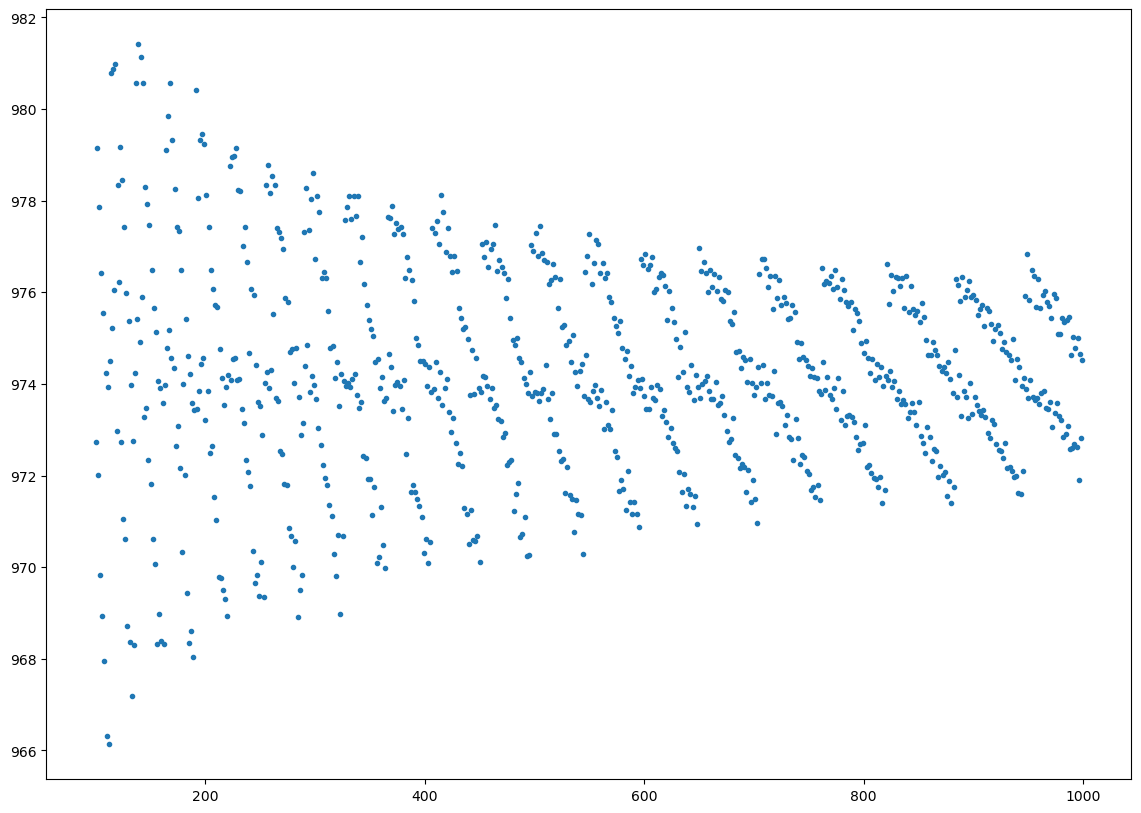

In [63]:
plt.figure(figsize=(14,10))
plt.plot(df['num_steps'], df['Value'], 'o', markersize=3)
plt.show()

In [66]:
Conv_value = Bin_icall(10000, S0, Face, ratio, sigma, r1, r2, T, cpn, tco, tac, DIV, TD)
Conv_value

u =  1.007610522766401 d= 0.9924655874444657
[1966.0, 3931.0, 5896.0, 7861.0, 9826.0]
124.92324050929385 123.98201727752259 123.04788560988635


([{'num_steps': 10000, 'Value': 974.6534884644569}],)

In [67]:
Bin_icall(10010, S0, Face, ratio, sigma, r1, r2, T, cpn, tco, tac, DIV, TD)

u =  1.0076067012091268 d= 0.9924693329666647
[1968.0, 3935.0, 5902.0, 7869.0, 9836.0]
124.92465487935043 123.98388889919971 123.0502075144018


([{'num_steps': 10010, 'Value': 974.5322177651393}],)

u =  1.0281646779208986 d= 0.9728502729334492
[148.0, 295.0, 443.0, 590.0, 737.0]
117.66163673741642 114.46715541379191 111.35940338622301
750
u =  1.0281265068074623 d= 0.9728857442849499
[148.0, 296.0, 444.0, 592.0, 739.0]
117.67450748300246 114.48385079596575 111.37970639024029
752
u =  1.0280884895308984 d= 0.9729210761241689
[149.0, 297.0, 445.0, 593.0, 741.0]
117.68732853972932 114.50048232905206 111.39993248431772
754
u =  1.0280506250631556 d= 0.9729562693654532
[149.0, 298.0, 446.0, 595.0, 743.0]
117.70010022842992 114.5170504221931 111.4200821575125
756
u =  1.0280129123857609 d= 0.9729913249147705
[149.0, 298.0, 447.0, 596.0, 745.0]
117.71282286703429 114.53355548085338 111.4401558945149
758
u =  1.0279753504897071 d= 0.9730262436698076
[150.0, 299.0, 449.0, 598.0, 747.0]
117.72549677060346 114.54999790686234 111.46015417569859
760
u =  1.027937938375339 d= 0.9730610265200684
[150.0, 300.0, 450.0, 599.0, 749.0]
117.73812225136292 114.56637809845651 111.48007747717038
762
u =

864
u =  1.0261769240893381 d= 0.9747020563507305
[171.0, 341.0, 511.0, 681.0, 851.0]
118.33480979584752 115.34118244588514 112.42328771192902
866
u =  1.0261462298239794 d= 0.9747307250395636
[171.0, 342.0, 512.0, 683.0, 853.0]
118.34525176712063 115.35475305995519 112.43982208688993
868
u =  1.026115642669188 d= 0.9747592959320912
[171.0, 342.0, 513.0, 684.0, 855.0]
118.35565872924664 115.36827857249932 112.4563019942268
870
u =  1.0260851620048594 d= 0.9747877695843196
[172.0, 343.0, 515.0, 686.0, 857.0]
118.36603087852203 115.38175923462319 112.4727277350333
872
u =  1.026054787215898 d= 0.9748161465478341
[172.0, 344.0, 516.0, 687.0, 859.0]
118.37636840970087 115.39519529547137 112.48909960806616
874
u =  1.0260245176921634 d= 0.9748444273698438
[173.0, 345.0, 517.0, 689.0, 861.0]
118.38667151601041 115.40858700224696 112.50541790976824
876
u =  1.025994352828421 d= 0.9748726125932264
[173.0, 346.0, 518.0, 691.0, 863.0]
118.39694038916643 115.42193460023117 112.52168293429187
878


980
u =  1.02455648757597 d= 0.9762186496751016
[193.0, 386.0, 579.0, 772.0, 965.0]
118.88804091009808 116.0607227597742 113.3006420528631
982
u =  1.0245311158719106 d= 0.9762424457075725
[194.0, 387.0, 581.0, 774.0, 967.0]
118.89673506681345 116.07203942827125 113.3144516497213
984
u =  1.0245058222298515 d= 0.9762661700709865
[194.0, 388.0, 582.0, 776.0, 969.0]
118.90540346034663 116.08332283697803 113.32822099517043
986
u =  1.024480606251167 d= 0.9762898231251411
[195.0, 389.0, 583.0, 777.0, 971.0]
118.91404621836178 116.09457314961928 113.34195028603057
988
u =  1.0244554675400723 d= 0.9763134052273071
[195.0, 390.0, 584.0, 779.0, 973.0]
118.92266346763653 116.1057905287893 113.3556397177707
990
u =  1.024430405703597 d= 0.9763369167322511
[195.0, 390.0, 585.0, 780.0, 975.0]
118.93125533406975 116.11697513596175 113.36928948452037
992
u =  1.0244054203515591 d= 0.9763603579922583
[196.0, 391.0, 586.0, 782.0, 977.0]
118.93982194268953 116.12812713149981 113.38289977908164
994
u = 

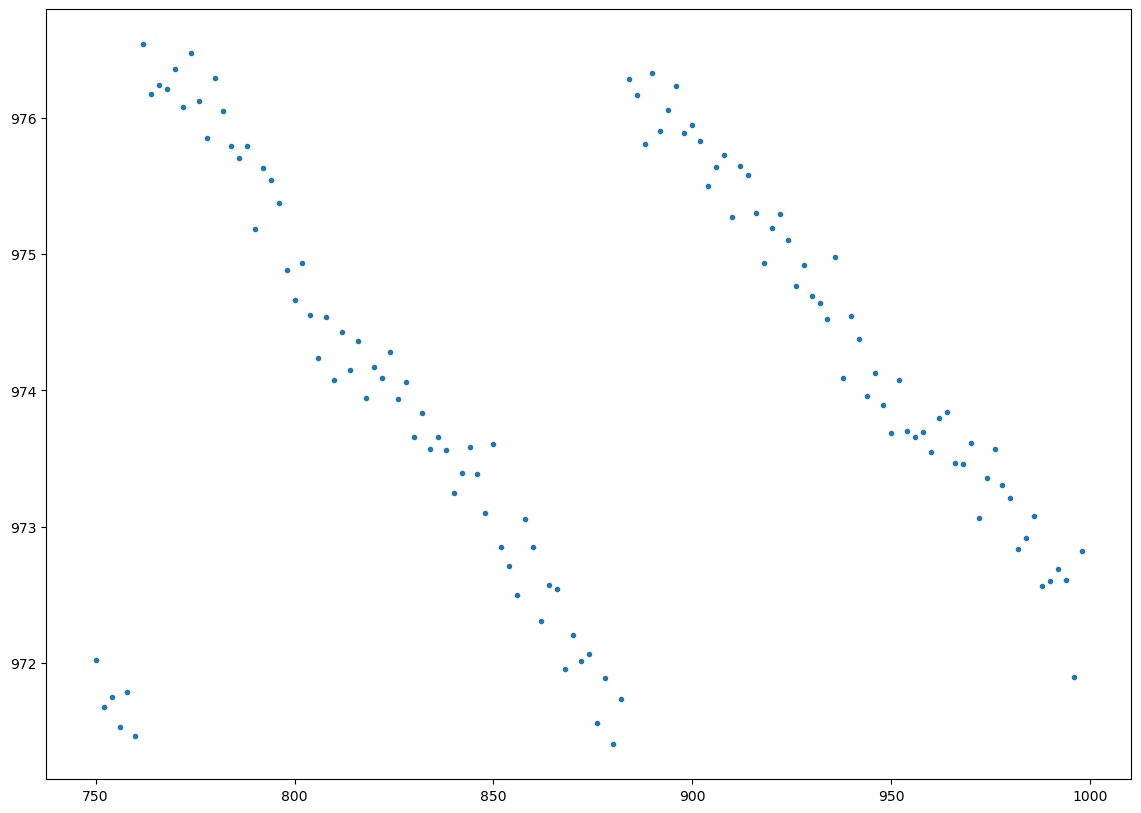

In [70]:
steps = np.arange(750, 1000, 2)
sst2 = []
for i in range(len(steps)):
    result = Bin_icall(steps[i], S0, Face, ratio, sigma, r1, r2, T, cpn, tco, tac, DIV, TD)
    sst2.append(result[0])
    print(steps[i])
df2 = pd.DataFrame.from_dict([i[0] for i in sst2])
plt.figure(figsize=(14,10))
plt.plot(df2['num_steps'], df2['Value'], 'o', markersize=3)
plt.show()

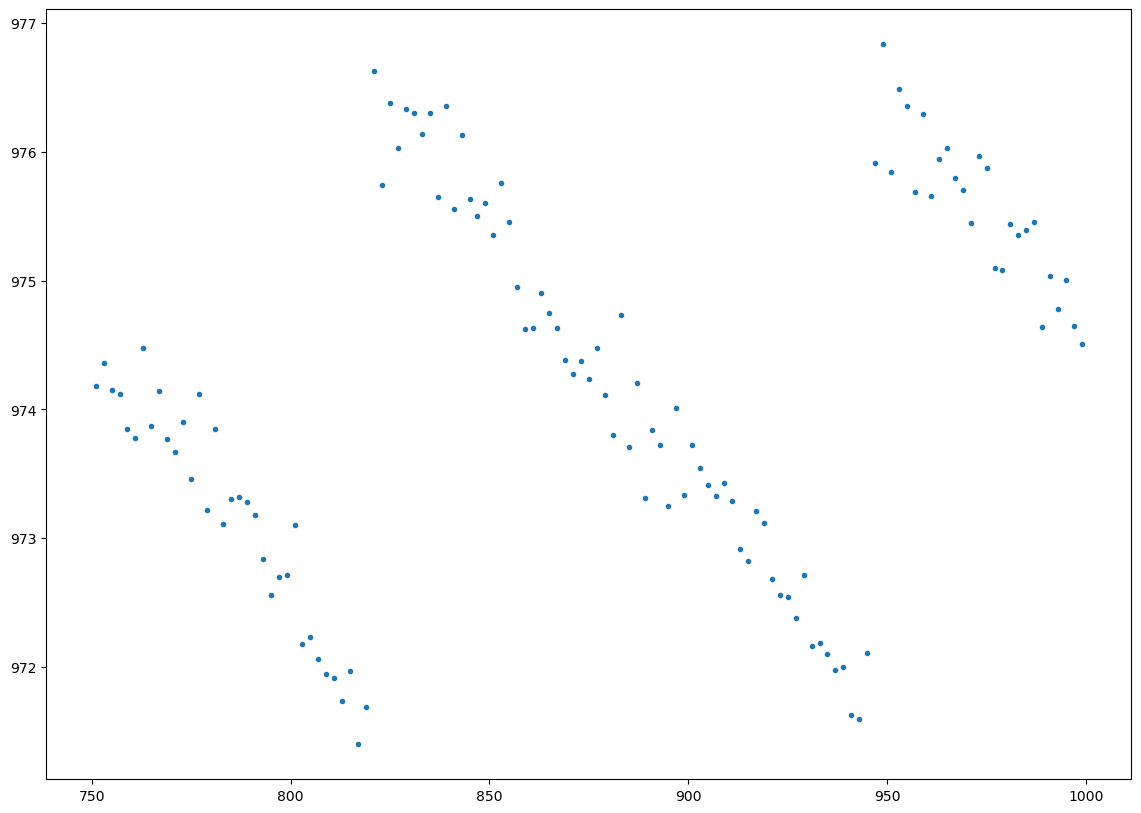

In [69]:
steps = np.arange(751, 1000, 2)

sst3 = []
for i in range(len(steps)):
    result = Bin_icall(steps[i], S0, Face, ratio, sigma, r1, r2, T, cpn, tco, tac, DIV, TD)
    sst3.append(result[0])
    print(steps[i])
df3 = pd.DataFrame.from_dict([i[0] for i in sst3])
plt.figure(figsize=(14,10))
plt.plot(df3['num_steps'], df3['Value'], 'o', markersize=3)
plt.show()

In [83]:

def Bin_icall2(N, S0, Face, ratio, sigma, r1, r2, T, cpn, tco, tac, DIV, TD):
    
    
    ######################################################################################
    def Stock_tree(N, S0, sigma, r, T, DIV, TD):
    
        stock_value = np.zeros([N+1, N+1])    

        delta = T / N
        u = np.exp(r*delta + sigma * (delta)**0.5)
        d = np.exp(r*delta - sigma * (delta)**0.5)
        print("u = ", u, "d=", d)

        # FIRST LET'S BUILD A STOCK PRICE TREE WITH DIVIDENDS  
        # Let's have dividends at grid points rather than times
        jD1 = [i/delta for i in TD]
        #print(jD1)
        jD = [np.ceil(i) for i in jD1]
        #print(jD)

        stock_value[0,0] = S0
        #print(stock_value[0,0])
        for j in range (1,N+1):
            stock_value[j, 0] = stock_value[j-1, 0]*d 
            for i in range(1, j+1):    
                stock_value[j, i] = stock_value[j-1, i-1]*u      

        # This adjusts all stock prices for that j by the size of the dividend    
            if j in jD: stock_value[j, :] *= (1-DIV)
        #print(stock_value[3,0], stock_value[4,0], stock_value[5,0])        
        return stock_value
    
    ######################################################################################
    
    stock_value = Stock_tree(N, S0, sigma, r1, T, DIV, TD)
    

    # LIST TO SAVE RESULTS
    icall_result = []
        
    # CREATE TWO DIMENSIONAL ARRAY OF SIZE [N+1,N+1] TO STORE ALL STEPS
    # option_value[N+1, N+1]
    option_value = np.zeros([N+1, N+1])
    
    #########################################################################################
    ex_boundary = np.zeros([N+1])
    option_tree = option_value
    ########################################################################################

    
    delta = T / N
    u = np.exp(r1*delta+sigma * (delta)**0.5)
    d = np.exp(r1*delta-sigma * (delta)**0.5)
    q = (np.exp(r1 * delta) - d) / (u - d)

    #First, let's calculate the coupon dates and accrued interest

    #jC1 are the exact values of j where the coupons are paid
    #jC are the values of j where we first factor in the coupons - 
    #where int will give us the j immediately before or on the call date
    jco1 = [j/delta for j in tco]
    jco = [int(j) for j in jco1]
    
    jac1 = [j/delta for j in tac]
    jac = [int(j) for j in jac1]
    #This converts the call times into times steps, 
    #where int will give us the j immediately before the call date
    
    j = N
    for i in range(0, j+1): 
        option_value[j, i] = (Face *(1+cpn))*np.exp(-r2*3/365) 
        if stock_value[j,i] < ratio*S0: option_value[j, i] = Face*(stock_value[j,i]/S0)*np.exp(-r2*3/365)
            
        ########################################################################
        ex_boundary[j] = round(option_value[j,i])
        option_tree[j,i] = round(option_value[j,i])
        ########################################################################
  
        
        
    for j in range(N-1, -1, -1):
        
        #######################################################################
        ex_boundary[j] = 0
        #########################################################################

        #if j in jac: print("call",j,jac.index(j))    
        for i in range(0, j+1):           
            cont = np.exp(-r2 * delta) * (q * option_value[j + 1, i + 1] + (1-q) * option_value[j + 1, i])

                    
            # the "if j in jC" is a really great Python command as it will check whether the entry ever occurs 
            # in the array jC. The index command is a little erratic but here will find the equivalent entry in 
            # the tc array - again a feature that may be helpful in future projects.

            if j in jac:
            
                if stock_value[j,i] >= ratio*S0: 
                    cont = cont + Face*cpn*np.exp(-r2*(tco[jac.index(j)]-delta*j))                        
                
                exe = Face *(1+cpn)
                cont = min(cont, exe)
                
            
            option_value[j,i] = cont
            
        ############################################################# use below line to plot barrier##################
        ex_boundary[j] = max(option_value[j,:])
        #if ex_boundary[j] > 1013: print(j)
        option_tree[j,i] = round(option_value[j,i])
        ##############################################################################################################

    output = {'num_steps': N, 'Value': option_value[0,0]}
    icall_result.append(output)

    return icall_result, ex_boundary, option_value

u =  1.0388312013976977 d= 0.963072094071381


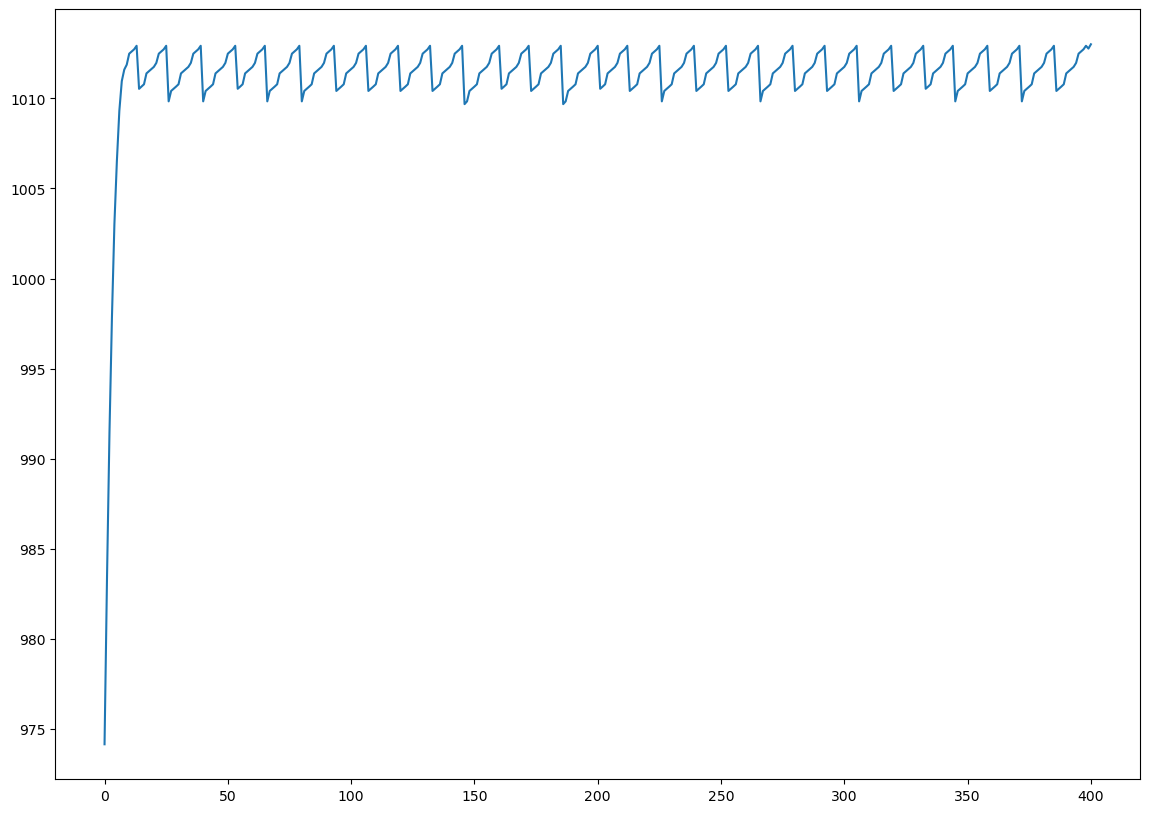

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,974.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,966.095490,983.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,956.500373,976.522796,991.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,945.656037,968.220514,985.612364,998.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,933.589568,958.640284,978.633374,993.331925,1003.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1012.441677,1012.441677,1012.441677,1012.441677,1012.441677,1013.000000,0.000000,0.000000,0.0,0.0
397,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1012.679144,1012.679144,1012.679144,1012.679144,1012.679144,1012.679144,1013.000000,0.000000,0.0,0.0
398,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1012.916667,1012.916667,1012.916667,1012.916667,1012.916667,1012.916667,1012.916667,1013.000000,0.0,0.0
399,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1012.762458,1012.762458,1012.762458,1012.762458,1012.762458,1012.762458,1012.762458,1012.762458,1013.0,0.0


In [84]:
# Plotting the barrier after adujusting Bin_icall function 

result = Bin_icall2(400, S0, Face, ratio, sigma, r1, r2, T, cpn, tco, tac, DIV, TD)
plt.figure(figsize=(14,10))
plt.plot(result[1])
plt.show()
pd.DataFrame(result[2])